In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA']   = "1"
from os import path as osp
# if 'jupyter' in os.getcwd():
#     os.chdir(osp.join(os.getcwd(), 'masterarbeit', 'code'))
import glob
import time
import argparse
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdmnotebook
import pickle
from pathlib import Path
from typing import Any
from typing import Callable
from typing import Optional
from typing import Tuple
from typing import Union
from typing import Dict
from typing import List
from itertools import cycle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
mpl.rc('axes', unicode_minus=False)
preamble = r'\usepackage{amsmath}'  # LaTeX preamble command
mpl.rcParams['text.latex.preamble'] = preamble

# import seaborn as sns
import networkx as nx
import math
import numpy as np

import gc

# pytorch imports
import torch
from torch import Tensor, nn, cuda
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.cuda.amp import GradScaler, autocast

# pytorch geometric imports
import torch_geometric
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Compose

# lightning imports
from lightning.pytorch.utilities.combined_loader import CombinedLoader

from IPython.display import display, clear_output

from google.cloud import storage

import sys
# Add the 'code' directory to sys.path to make the  submodules available
# sys.path.append('/home/jupyter/masterarbeit/code')

from util.utils import generate_log_name
from util.plot_utils import *

import logging as log

from data.dataset.GraphDataset import GraphDataset

from model.transform import CollapseChannels, ExtractSquare
from model.autoencoder import Autoencoder
from model.predictor import Predictor
from model.DAN import GradientReversalLayer, DomainDiscriminator

from model.criterions import WeightedMSELoss, MSLELoss, FocalLoss, ZeroInflatedLoss, CustomHuberLoss

from fullmodel import Model

API_KEY_PATH = 'api_key.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = API_KEY_PATH

In [4]:
exp_id='exp11'

In [1]:
setups = [(i, j) for i in [1, 2] for j in [1, 2, 3]]

In [9]:
EPOCHS: int = 2
N_weeks = 2
N_src = 3
BATCH_SIZE: int = 2
NUM_CHANNELS: int = 2
WDW_LENGTH: list = [12, 6]
src_data_limit: int = None

tgt: str = 'MELBOURNE'
src_list: list = ['ANTWERP', 'BANGKOK', 'BARCELONA', 'BERLIN', 'CHICAGO', 'ISTANBUL', 'MOSCOW']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TRAIN_VAL_TEST_SPLIT = [0.8, 0.1, 0.1]

pre_transform = Compose([
    CollapseChannels(),
])

ds_kwargs = {
    'root_dir': 'data/raw',
    'device': device,
    'pre_transform': pre_transform,
}

# seed generator for DataLoader
gen = torch.manual_seed(2311)

In [133]:
# setups = [(i, j) for i in [1, 2] for j in [1, 2, 3]]

# rec_errors = {}
for N_weeks in [1, 2]:
    specs = f'{N_weeks}_0'
    # src_list: list = ['ANTWERP', 'BANGKOK', 'BARCELONA', 'BERLIN', 'CHICAGO', 'ISTANBUL', 'MOSCOW'][:N_src]

    TRAIN_VAL_TEST_SPLIT_TGT = [
            N_weeks*0.04,
            0.04,
            1 - (N_weeks+1)*0.04
        ]
    # Create datasets for each city
    ds_dict = {}
    for city in src_list:
        ds_dict[city] = GraphDataset(
            cities=[city],
            limit=src_data_limit,
            **ds_kwargs,
        )
        
    temp_tgt = GraphDataset(
        cities=[tgt],
        limit=None,
        **ds_kwargs,
    )
    
    train_tgt, val_tgt, test_tgt = random_split(
        temp_tgt, TRAIN_VAL_TEST_SPLIT_TGT,
        generator=gen
    )
    
    
    train_tgt = DataLoader(
        train_tgt, batch_size=BATCH_SIZE, shuffle=True,
        drop_last=True, generator=gen
    )
    val_tgt   = DataLoader(
        val_tgt, batch_size=BATCH_SIZE, shuffle=True,
        drop_last=True, generator=gen
    )
    test_tgt  = DataLoader( 
        test_tgt, batch_size=BATCH_SIZE, shuffle=False,
        drop_last=True, generator=gen
    )
    # Split each dataset into training and test sets
    train = {}
    val   = {}
    test  = {}
    for city in ds_dict:
        train_ds, val_ds, test_ds = random_split(
            ds_dict[city], TRAIN_VAL_TEST_SPLIT
        )
        train[city] = DataLoader(
            train_ds, batch_size=BATCH_SIZE, shuffle=True,
            drop_last=True, generator=gen
        )
        val[city]   = DataLoader(
            val_ds, batch_size=BATCH_SIZE, shuffle=True,
            drop_last=True, generator=gen
        )
        test[city]  = DataLoader(
            test_ds, batch_size=BATCH_SIZE, shuffle=False,
            drop_last=True, generator=gen
        )
    
    train[tgt] = train_tgt
    val[tgt]   = val_tgt
    test[tgt]  = test_tgt
    
    # Create dataloader for offline training with source cities
    source_train = {city: train[city] for city in src_list}
    source_dataloader = CombinedLoader(source_train, mode='max_size_cycle')
    
    source_test = {city: test[city] for city in src_list}
    sourcetest_dataloader = CombinedLoader(source_test, mode='max_size_cycle')
    
    target_dataloader = CombinedLoader({tgt: train[tgt]}, mode='max_size_cycle')
    targettest_dataloader = CombinedLoader({tgt: test[tgt]}, mode='max_size_cycle')
    
    # Create dataloader for online training with source and target cities
    train_dataloader = CombinedLoader(train, mode='max_size_cycle')
    
    # Create dataloader for validation with source and target cities
    val_dataloader = CombinedLoader(val, mode='max_size_cycle')
    
    # Create dataloader for testing with source and target cities
    test_dataloader = CombinedLoader(test, mode='max_size_cycle')

    ##############################################################################
    ########################## INSTANTIATING THE MODEL ###########################
    ##############################################################################
    USE_LAYER_NORM=True
    
    AE_K_CHEB = 3
    AE_CONV_DIM = 16
    AE_LINEAR_DIM = 8
    AE_DROPOUT = 0.5
    AE_ACTIVATION = 'sigmoid'
    
    AE_parameters = {
        'K_cheb': AE_K_CHEB,
        'conv_dim': AE_CONV_DIM,
        'linear_dim': AE_LINEAR_DIM,
        'dropout': AE_DROPOUT,
        'activation': AE_ACTIVATION,
        'num_channels': NUM_CHANNELS,
        'device': device,
        'use_layer_norm': USE_LAYER_NORM
    }
    
    DD_SEQ_LEN = 12
    DD_FEAT_DIM = AE_LINEAR_DIM
    DD_LEFT_NODES = 1750
    DD_parameters = {
        'seq_len': DD_SEQ_LEN,
        'feat_dim': DD_FEAT_DIM,
        'left_nodes': DD_LEFT_NODES,
        'use_layer_norm': USE_LAYER_NORM
    }
    
    # autoencoder linear dims + 4 sin-cos time features
    PRED_FEATURES   = AE_LINEAR_DIM + 4
    PRED_LINEAR_DIM = 32
    PRED_PERIODS_IN = 12
    PRED_PERIODS_OUT = [0, 1, 2, 5, 8, 11]
    PRED_ACTIVATION  = 'relu'
    
    PR_parameters = {
        'features': PRED_FEATURES,
        'linear_dim': PRED_LINEAR_DIM,
        'periods_in': PRED_PERIODS_IN,
        'periods_out': PRED_PERIODS_OUT,
        'activation': PRED_ACTIVATION,
        'num_channels': NUM_CHANNELS,
        'device': device,
        'batch_size': BATCH_SIZE,
        'use_layer_norm': USE_LAYER_NORM
        
    }
    num_epochs = EPOCHS
    dataloaders = train_dataloader, target_dataloader, targettest_dataloader
    AE_criterion = nn.MSELoss()
    PR_criterion = nn.MSELoss()
    optimizer_parameters = 5e-4, 5e-5
    BATCH_SIZE = BATCH_SIZE
    dd_lambda = 0.01
    
    folder = osp.join('training logs', 'models', exp_id)
    check_dir(folder)
    
    
    model = Model(
        AE_parameters=AE_parameters,
        DD_parameters=DD_parameters,
        PR_parameters=PR_parameters,
        num_epochs=num_epochs,
        dataloaders=dataloaders,
        AE_criterion=AE_criterion,
        PR_criterion=PR_criterion,
        optimizer_parameters=optimizer_parameters,
        BATCH_SIZE=BATCH_SIZE,
        dd_lambda=dd_lambda,
        folder=folder,
        specs=specs,
        tgt=tgt,
        val_dl=val_dataloader,
        lr_scheduler=(8500, 0.85)
    ).to(device)
    step = 64//BATCH_SIZE
    # print(f"==================== AE PT ====================")
    # model.ae_train(
    #     'pretrain', 
    #     save=False, 
    #     lambda_update=1.5, 
    #     plot=1, 
    #     accumulation_steps=step
    # )
    
    print(f"==================== AE FT ====================")
    model.ae_train(
        'finetune', 
        save=True, 
        plot=1,
        accumulation_steps=step//4
    )
    
    # print(f"==================== PR PT ====================")
    # model.pred_train(
    #     'pretrain', 
    #     save=False, 
    #     plot=1, 
    #     accumulation_steps=step
    # )
    
    print(f"==================== PR FT ====================")
    model.pred_train(
        'finetune', 
        save=True, 
        plot=1,
        accumulation_steps=step//4
    )
    
    # model.load_module('autoencoder', folder, f'ae_{specs}.pth')
    # model.load_module('discriminator', folder, f'dd_{specs}.pth')
    # model.load_module('predictor', folder, f'pred_{specs}.pth')
    # 

    errors = model.ae_test(crit=['MAE', 'RMSE'], sample_limit=2000)
    rec_errors[specs] = errors

    errors = model.pred_test(sample_limit=4000, crit=['MAE', 'RMSE'])
    test_errors[specs] = errors

==================== AE FT ====================


Epochs:   0%|          | 0/2 [00:00<?,?it/s]

Batches:   0%|          | 0/865 [00:00<?,?it/s]

Batch:  28
    Loss:    0.2808
     Rec:    0.2808
    Disc:    0.0000
Batch:  56
    Loss:    0.2774
     Rec:    0.2774
    Disc:    0.0000
Batch:  84
    Loss:    0.2739
     Rec:    0.2739
    Disc:    0.0000
Batch:  112
    Loss:    0.2695
     Rec:    0.2695
    Disc:    0.0000
Batch:  140
    Loss:    0.2665
     Rec:    0.2665
    Disc:    0.0000
Batch:  168
    Loss:    0.2623
     Rec:    0.2623
    Disc:    0.0000
Batch:  196
    Loss:    0.2594
     Rec:    0.2594
    Disc:    0.0000


/home/jolenscki/masterarbeit/code/util/plot_utils.py:150: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


Batch:  224
    Loss:    0.2565
     Rec:    0.2565
    Disc:    0.0000
Batch:  252
    Loss:    0.2543
     Rec:    0.2543
    Disc:    0.0000
Batch:  280
    Loss:    0.2501
     Rec:    0.2501
    Disc:    0.0000
Batch:  308
    Loss:    0.2478
     Rec:    0.2478
    Disc:    0.0000
Batch:  336
    Loss:    0.2455
     Rec:    0.2455
    Disc:    0.0000
Batch:  364
    Loss:    0.2439
     Rec:    0.2439
    Disc:    0.0000
Batch:  392
    Loss:    0.2411
     Rec:    0.2411
    Disc:    0.0000
Batch:  420
    Loss:    0.2395
     Rec:    0.2395
    Disc:    0.0000
Batch:  448
    Loss:    0.2378
     Rec:    0.2378
    Disc:    0.0000
Batch:  476
    Loss:    0.2366
     Rec:    0.2366
    Disc:    0.0000
Batch:  504
    Loss:    0.2351
     Rec:    0.2351
    Disc:    0.0000
Batch:  532
    Loss:    0.2341
     Rec:    0.2341
    Disc:    0.0000
Batch:  560
    Loss:    0.2331
     Rec:    0.2331
    Disc:    0.0000
Batch:  588
    Loss:    0.2320
     Rec:    0.2320
    Disc:   

Epochs:   0%|          | 0/2 [00:00<?,?it/s]

Batches:   0%|          | 0/865 [00:00<?,?it/s]

Batch:  28
    Loss:    0.2474
Batch:  56
    Loss:    0.2434
Batch:  84
    Loss:    0.2373
Batch:  112
    Loss:    0.2304
Batch:  140
    Loss:    0.2329
Batch:  168
    Loss:    0.2342
Batch:  196
    Loss:    0.2295
Batch:  224
    Loss:    0.2227
Batch:  252
    Loss:    0.2157
Batch:  280
    Loss:    0.2181
Batch:  308
    Loss:    0.2155
Batch:  336
    Loss:    0.2062
Batch:  364
    Loss:    0.2071
Batch:  392
    Loss:    0.2032
Batch:  420
    Loss:    0.1993
Batch:  448
    Loss:    0.1964
Batch:  476
    Loss:    0.1925
Batch:  504
    Loss:    0.1854
Batch:  532
    Loss:    0.1875
Batch:  560
    Loss:    0.1818
Batch:  588
    Loss:    0.1712
Batch:  616
    Loss:    0.1704
Batch:  644
    Loss:    0.1686
Batch:  672
    Loss:    0.1625
Batch:  700
    Loss:    0.1560
Batch:  728
    Loss:    0.1555
Batch:  756
    Loss:    0.1579
Batch:  784
    Loss:    0.1389
Batch:  812
    Loss:    0.1446
Batch:  840
    Loss:    0.1367
Batch:  28
    Loss:    0.1279
Batch:  56
 

Batches:   0%|          | 0/2000 [00:00<?,?it/s]

Batches:   0%|          | 0/4000 [00:00<?,?it/s]

==================== AE FT ====================


Epochs:   0%|          | 0/2 [00:00<?,?it/s]

Batches:   0%|          | 0/1729 [00:00<?,?it/s]

Batch:  57
    Loss:    0.3557
     Rec:    0.3557
    Disc:    0.0000
Batch:  114
    Loss:    0.3422
     Rec:    0.3422
    Disc:    0.0000
Batch:  171
    Loss:    0.3310
     Rec:    0.3310
    Disc:    0.0000
Batch:  228
    Loss:    0.3210
     Rec:    0.3210
    Disc:    0.0000
Batch:  285
    Loss:    0.3138
     Rec:    0.3138
    Disc:    0.0000
Batch:  342
    Loss:    0.3094
     Rec:    0.3094
    Disc:    0.0000
Batch:  399
    Loss:    0.3035
     Rec:    0.3035
    Disc:    0.0000
Batch:  456
    Loss:    0.2998
     Rec:    0.2998
    Disc:    0.0000
Batch:  513
    Loss:    0.2959
     Rec:    0.2959
    Disc:    0.0000
Batch:  570
    Loss:    0.2913
     Rec:    0.2913
    Disc:    0.0000
Batch:  627
    Loss:    0.2869
     Rec:    0.2869
    Disc:    0.0000
Batch:  684
    Loss:    0.2837
     Rec:    0.2837
    Disc:    0.0000
Batch:  741
    Loss:    0.2804
     Rec:    0.2804
    Disc:    0.0000
Batch:  798
    Loss:    0.2769
     Rec:    0.2769
    Disc:    

Epochs:   0%|          | 0/2 [00:00<?,?it/s]

Batches:   0%|          | 0/1729 [00:00<?,?it/s]

Batch:  57
    Loss:    0.2636
Batch:  114
    Loss:    0.2553
Batch:  171
    Loss:    0.2368
Batch:  228
    Loss:    0.2457
Batch:  285
    Loss:    0.2274
Batch:  570
    Loss:    0.1804
Batch:  627
    Loss:    0.1773
Batch:  684
    Loss:    0.1608
Batch:  741
    Loss:    0.1513
Batch:  798
    Loss:    0.1402
Batch:  855
    Loss:    0.1333
Batch:  912
    Loss:    0.1266
Batch:  969
    Loss:    0.1120
Batch:  1026
    Loss:    0.1021
Batch:  1083
    Loss:    0.0945
Batch:  1140
    Loss:    0.0844
Batch:  1197
    Loss:    0.0818
Batch:  1254
    Loss:    0.0722
Batch:  1311
    Loss:    0.0610
Batch:  1368
    Loss:    0.0612
Batch:  1425
    Loss:    0.0515
Batch:  1482
    Loss:    0.0390
Batch:  1539
    Loss:    0.0362
Batch:  1596
    Loss:    0.0293
Batch:  1653
    Loss:    0.0260
Batch:  1710
    Loss:    0.0241
Batch:  57
    Loss:    0.0199
Batch:  114
    Loss:    0.0187
Batch:  171
    Loss:    0.0174
Batch:  228
    Loss:    0.0148
Batch:  285
    Loss:    0.01

Batches:   0%|          | 0/2000 [00:00<?,?it/s]

Batches:   0%|          | 0/4000 [00:00<?,?it/s]

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [1]:
hidden_dim = [8, 16, 32, 64, 16]

In [8]:
import torch.nn as nn

In [9]:
seq = nn.Sequential()

In [16]:
seq[0]

Linear(in_features=1, out_features=1, bias=True)

In [3]:
[2] + [el for el in hidden_dim[1::2]]

[2, 16, 64]

In [151]:
test_errors = {k: v for k, v in sorted(test_errors.items())}

In [153]:
for k, v in test_errors.items():
    print('N_weeks N_src', k)
    print('MAE MEDIAN', v['MAE'].median())
    print('RMSE MEDIAN', v['RMSE'].median())
    print('-------------------------------')

N_weeks N_src 1_0
MAE MEDIAN tensor(0.1626, device='cuda:0')
RMSE MEDIAN tensor(0.1695, device='cuda:0')
-------------------------------
N_weeks N_src 1_1
MAE MEDIAN tensor(0.0018, device='cuda:0')
RMSE MEDIAN tensor(0.0171, device='cuda:0')
-------------------------------
N_weeks N_src 1_2
MAE MEDIAN tensor(0.0017, device='cuda:0')
RMSE MEDIAN tensor(0.0171, device='cuda:0')
-------------------------------
N_weeks N_src 1_3
MAE MEDIAN tensor(0.0019, device='cuda:0')
RMSE MEDIAN tensor(0.0173, device='cuda:0')
-------------------------------
N_weeks N_src 2_0
MAE MEDIAN tensor(0.0356, device='cuda:0')
RMSE MEDIAN tensor(0.0404, device='cuda:0')
-------------------------------
N_weeks N_src 2_1
MAE MEDIAN tensor(0.0017, device='cuda:0')
RMSE MEDIAN tensor(0.0171, device='cuda:0')
-------------------------------
N_weeks N_src 2_2
MAE MEDIAN tensor(0.0020, device='cuda:0')
RMSE MEDIAN tensor(0.0166, device='cuda:0')
-------------------------------
N_weeks N_src 2_3
MAE MEDIAN tensor(0.003

In [156]:
def plot_median_error(
    dict_values, 
    metric='RMSE', 
    values=[1, 2, 3],
    xlabel='# sources',
    save=True,
    exp_id='exp',
    specs=''
):
    new_dict = {}
    for k, v in dict_values.items():
        key = k.split('_')[0]
        if key not in new_dict:
            new_dict[key] = []
        value = v[metric]
        if hasattr(value, 'device'):
            value = value.cpu().numpy()
        if int(k.split('_')[1]) in values:
            new_dict[key].append(value)
    
    cmap = mpl.colormaps.get_cmap('Pastel1')
    colors = [cmap(i/(4*len(new_dict))) for i in range(4*len(new_dict))]
    fig, ax = plt.subplots(figsize=(8, 5))    

    _max = 0
    _min = 99
    for i, (k, v) in enumerate(new_dict.items()):
        y = [np.median(el) for el in v]
        yerr = [np.std(el) for el in v]
        plt.errorbar(values, y, yerr=yerr, fmt='o', linestyle='--', c=colors[i], label=k, capsize=3)

        _max = max(_max, max([el.max() for el in v]))
        _min = min(_min, min([el.min() for el in v]))


    # change the style of the axis spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['right'].set_position(('outward', 4))

    ax.spines['left'].set_position(('outward', 4))
    ax.spines['bottom'].set_position(('outward', 4))
    ax.spines['bottom'].set_bounds(values[0], values[-1])

    ax.set_xlabel(xlabel, fontsize=15, color = '#333F4B')
    ax.set_ylabel(metric, fontsize=15, color = '#333F4B')
    
    ax.set_ylim(bottom=1.05*_min, top=_max)
    ax.set_xlim(left=.95*values[0], right=1.05*values[-1])

    ax.set_xticks(values)

    plt.legend(title='# weeks', labelcolor = '#333F4B')

    plt.tight_layout()
    if save:
        check_dir(osp.join('figures', exp_id))
        plt.savefig(osp.join('figures', exp_id, f'median_{metric}_{specs}.pdf'), dpi=200, format='pdf')
        plt.clf()
    else:
        plt.show()

In [159]:
plot_median_error(rec_errors, save=True, values=[1, 2, 3], specs='rec_errors')

<Figure size 800x500 with 0 Axes>

In [160]:
plot_median_error(test_errors, save=True, values=[1, 2, 3], specs='pred_errors')

<Figure size 800x500 with 0 Axes>

In [162]:
fn = osp.join(folder, 'rec_dict.pkl')
with open(fn, 'wb') as f:
    pickle.dump(rec_errors, f)

In [8]:
##############################################################################
########################## INSTANTIATING THE MODEL ###########################
##############################################################################
USE_LAYER_NORM=True

AE_K_CHEB = 3
AE_CONV_DIM = 16
AE_LINEAR_DIM = 8
AE_DROPOUT = 0.5
AE_ACTIVATION = 'sigmoid'

AE_parameters = {
    'K_cheb': AE_K_CHEB,
    'conv_dim': AE_CONV_DIM,
    'linear_dim': AE_LINEAR_DIM,
    'dropout': AE_DROPOUT,
    'activation': AE_ACTIVATION,
    'num_channels': NUM_CHANNELS,
    'device': device,
    'use_layer_norm': USE_LAYER_NORM
}

DD_SEQ_LEN = 12
DD_FEAT_DIM = AE_LINEAR_DIM
DD_LEFT_NODES = 1750
DD_parameters = {
    'seq_len': DD_SEQ_LEN,
    'feat_dim': DD_FEAT_DIM,
    'left_nodes': DD_LEFT_NODES,
    'use_layer_norm': USE_LAYER_NORM
}

# autoencoder linear dims + 4 sin-cos time features
PRED_FEATURES   = AE_LINEAR_DIM + 4
PRED_LINEAR_DIM = 32
PRED_PERIODS_IN = 12
PRED_PERIODS_OUT = [0, 1, 2, 5, 8, 11]
PRED_ACTIVATION  = 'relu'

PR_parameters = {
    'features': PRED_FEATURES,
    'linear_dim': PRED_LINEAR_DIM,
    'periods_in': PRED_PERIODS_IN,
    'periods_out': PRED_PERIODS_OUT,
    'activation': PRED_ACTIVATION,
    'num_channels': NUM_CHANNELS,
    'device': device,
    'batch_size': BATCH_SIZE,
    'use_layer_norm': USE_LAYER_NORM
    
}
num_epochs = EPOCHS
dataloaders = train_dataloader, target_dataloader, targettest_dataloader
AE_criterion = nn.MSELoss()
PR_criterion = nn.MSELoss()
optimizer_parameters = 5e-4, 5e-5
BATCH_SIZE = BATCH_SIZE
dd_lambda = 0.01

folder = osp.join('training logs', 'models', exp_id)
check_dir(folder)


model = Model(
    AE_parameters=AE_parameters,
    DD_parameters=DD_parameters,
    PR_parameters=PR_parameters,
    num_epochs=num_epochs,
    dataloaders=dataloaders,
    AE_criterion=AE_criterion,
    PR_criterion=PR_criterion,
    optimizer_parameters=optimizer_parameters,
    BATCH_SIZE=BATCH_SIZE,
    dd_lambda=dd_lambda,
    folder=folder,
    specs=specs,
    tgt=tgt,
    val_dl=val_dataloader,
    lr_scheduler=(8500, 0.85)
).to(device)


model.load_module('autoencoder', folder, f'ae_{specs}.pth')
model.load_module('discriminator', folder, f'dd_{specs}.pth')
model.load_module('predictor', folder, f'pred_{specs}.pth')
step = 64//BATCH_SIZE

# print(f"==================== AE PT ====================")
# model.ae_train(
#     'pretrain', 
#     save=False, 
#     lambda_update=1.5, 
#     plot=1, 
#     accumulation_steps=step
# )

# print(f"==================== AE FT ====================")
# model.ae_train(
#     'finetune', 
#     save=True, 
#     plot=1,
#     accumulation_steps=step//4
# )

# print(f"==================== PR PT ====================")
# model.pred_train(
#     'pretrain', 
#     save=False, 
#     plot=1, 
#     accumulation_steps=step
# )

# print(f"==================== PR FT ====================")
# model.pred_train(
#     'finetune', 
#     save=True, 
#     plot=1,
#     accumulation_steps=step//4
# )

errors = model.pred_test(sample_limit=4000, crit=['MAE', 'RMSE'])


Batches:   0%|          | 0/4000 [00:00<?,?it/s]

In [ ]:
fn = osp.join(folder, 'errors_dict.pkl')
with open(fn, 'rb') as f:
    test_errors = pickle.load(f)
test_errors[specs] = errors
with open(fn, 'wb') as f:
    pickle.dump(test_errors, f)


plot_losses_boxplot(
    test_errors,
    r'N_weeks, N_src', 
    save=False,
    errors=list(errors.keys()),
    exp_id=exp_id,
)

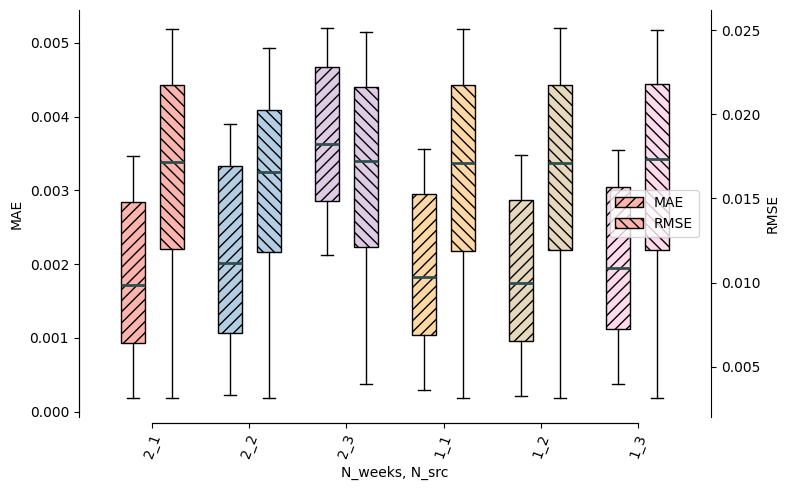

In [12]:
plot_losses_boxplot(
    test_errors,
    r'N_weeks, N_src', 
    save=False,
    errors=list(errors.keys()),
    exp_id=exp_id,
)

In [10]:
test_errors.pop('2_2_old', None)

{'MAE': tensor([0.0010, 0.0020, 0.0002,  ..., 0.0003, 0.0008, 0.0004], device='cuda:0'),
 'RMSE': tensor([0.0135, 0.0197, 0.0045,  ..., 0.0055, 0.0120, 0.0083], device='cuda:0')}

In [29]:
test_errors

{'2_1': {'MAE': tensor([0.0011, 0.0021, 0.0003,  ..., 0.0003, 0.0009, 0.0005], device='cuda:0'),
  'RMSE': tensor([0.0135, 0.0197, 0.0045,  ..., 0.0055, 0.0120, 0.0083], device='cuda:0')},
 '2_2': {'MAE': tensor([0.0013, 0.0024, 0.0003,  ..., 0.0003, 0.0010, 0.0005], device='cuda:0'),
  'RMSE': tensor([0.0132, 0.0190, 0.0045,  ..., 0.0055, 0.0120, 0.0083], device='cuda:0')},
 '2_3': {'MAE': tensor([0.0030, 0.0039, 0.0022,  ..., 0.0044, 0.0038, 0.0045], device='cuda:0'),
  'RMSE': tensor([0.0136, 0.0197, 0.0051,  ..., 0.0219, 0.0186, 0.0204], device='cuda:0')},
 '1_1': {'MAE': tensor([0.0030, 0.0005, 0.0033,  ..., 0.0007, 0.0027, 0.0020], device='cuda:0'),
  'RMSE': tensor([0.0217, 0.0065, 0.0236,  ..., 0.0088, 0.0210, 0.0183], device='cuda:0')},
 '1_2': {'MAE': tensor([0.0030, 0.0004, 0.0032,  ..., 0.0006, 0.0026, 0.0019], device='cuda:0'),
  'RMSE': tensor([0.0217, 0.0065, 0.0236,  ..., 0.0088, 0.0210, 0.0183], device='cuda:0')},
 '1_3': {'MAE': tensor([0.0031, 0.0006, 0.0033,  ..., 0